### Visualize DeepHAM Solution (code on Nuvolos)

In [1]:
!/opt/bin/nvidia-smi

Tue Aug 26 01:12:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/DeepHAM_Turin/src')
os.getcwd()

'/content/drive/MyDrive/DeepHAM_Turin/src'

In [4]:
!pip install quantecon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 20.8 MB/s eta 0:00:00


## Change to the code directory on Nuvolos

In [5]:
# import os
# os.chdir('/files/day2/Yang/code/DeepHAM_nuvolos/src')
# os.getcwd()

## Imports, config, load solved policy

In [19]:
import os, json, time, random
import numpy as np
import tensorflow as tf
import statsmodels.api as sm  # (if you later need it)
from matplotlib import pyplot as plt
import matplotlib

from param import KSParam
from dataset import KSInitDataSet
from value import ValueTrainer
from policy import KSPolicyTrainer
from simulation_KS import simul_shocks, simul_k
from util import print_elapsedtime

plt.rcParams.update({'font.size': 28})

# --- determinism
seed_value = 996
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
tf.config.experimental.enable_op_determinism()

start_time = time.monotonic()

# --- where trained models live
model_path = "../data/simul_results/KS/game_nn_n50_1gm3"
with open(os.path.join(model_path, "config.json"), "r") as f:
    config = json.load(f)

# ensure dataset uses simul_config.n_path
config["dataset_config"]["n_path"] = config["simul_config"]["n_path"]
config["init_with_bchmk"] = True

# --- parameters & dataset
mparam   = KSParam(config["n_agt"], config["beta"], config["mats_path"])
init_ds  = KSInitDataSet(mparam, config)
vconf    = config["value_config"]

# --- load value nets
vtrainers = [ValueTrainer(config) for _ in range(vconf["num_vnet"])]
for i, vtr in enumerate(vtrainers):
    vtr.load_model(os.path.join(model_path, f"value{i}.weights.h5"))

# --- load policy
ptrainer = KSPolicyTrainer(vtrainers, init_ds, os.path.join(model_path, "policy.weights.h5"))

## Long simulation (same shocks) for KS benchmark vs DeepHAM

In [20]:
# shared shocks
simul_conf = config["simul_config"]
n_path     = simul_conf["n_path"]
n_agt      = config["n_agt"]
T          = simul_conf["T"]

state_init = init_ds.next_batch(n_path)
shocks     = simul_shocks(n_path, T, mparam, state_init)

# KS benchmark (PDE/bspline)
simul_data_bchmk = simul_k(
    n_path, T, mparam,
    init_ds.k_policy_bchmk,
    policy_type="pde",
    state_init=state_init,
    shocks=shocks,
)

# DeepHAM policy (NN)
simul_data_nn = simul_k(
    n_path, T, mparam,
    ptrainer.current_c_policy,
    policy_type="nn_share",
    state_init=state_init,
    shocks=shocks,
)

ashock, ishock = shocks[0], shocks[1]  # ashock: [paths, T], ishock: [paths, n_agt, T]

print_elapsedtime(time.monotonic() - start_time)

Elapsed time: 00:00:23.64


## Visualize generalized moments (GM)

**Idea.** Pass normalized $k$ through each value net’s `gm_model.basis_fn`, average across agents to get the GM, and show (i) a basis slice vs. assets, (ii) distributions of GMs.


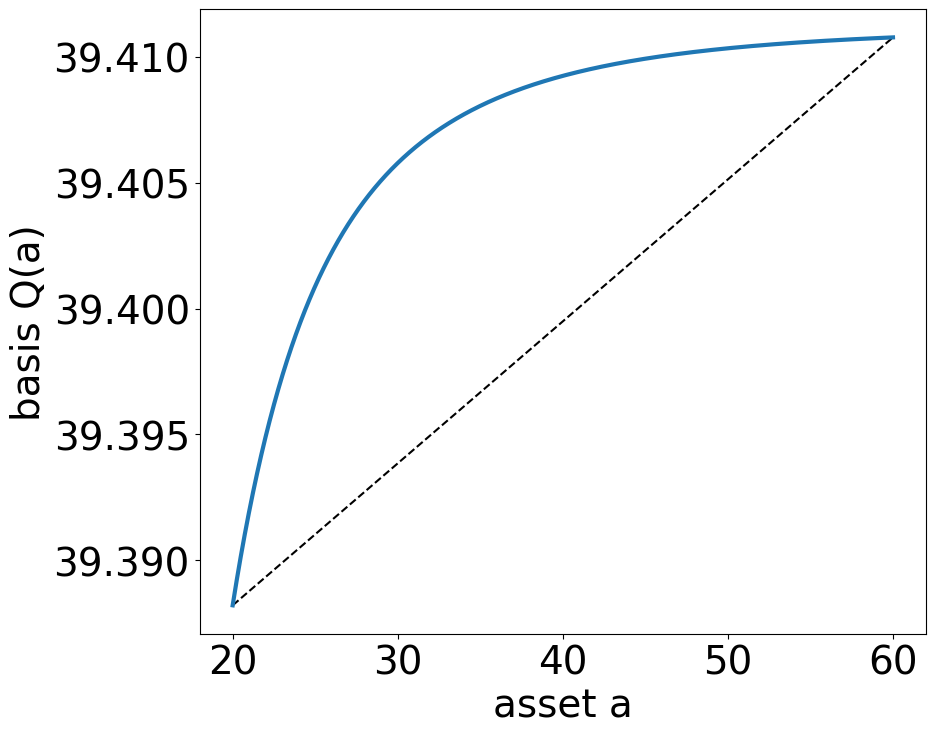

In [21]:
def gm_from_knormed(knormed, gm_model):
    """
    knormed: [paths, n_agt, T]
    returns: basis [paths, n_agt, T, d_gm], gm [paths, 1, T, d_gm]
    """
    x = knormed.transpose(0, 2, 1)[:, :, :, None]          # [B,T,n_agt,1]
    basis = gm_model.basis_fn(x).numpy()                   # [B,T,n_agt,d_gm]
    basis = basis.transpose(0, 2, 1, 3)                    # [B,n_agt,T,d_gm]
    gm = np.mean(basis, axis=1, keepdims=True)             # [B,1,T,d_gm]
    return basis, gm

# use DeepHAM paths to visualize GM
k_cross  = simul_data_nn["k_cross"]                        # [B,n_agt,T]
knormed  = ptrainer.init_ds.normalize_data(k_cross, key="agt_s")

basis_list, gm_list = [], []
for vtr in vtrainers:
    basis_i, gm_i = gm_from_knormed(knormed, vtr.gm_model)
    basis_list.append(basis_i)
    gm_list.append(gm_i)

# pick one basis channel from vtrainers[0] and show how it varies with k
b = basis_list[0][..., 0]                                  # [B,n_agt,T] pick gm-dim 0
b = b.reshape(-1)
k = k_cross.reshape(-1)

# normalize b to comparable scale (optional)
b = b / b.mean() * k_cross.mean()

mask = (k > 20) & (k < 60)
k1, b1 = k[mask], b[mask]
idx = np.argsort(k1)

fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111)
ax.plot([k1[idx][0], k1[idx][-1]], [b1[idx][0], b1[idx][-1]], "k--")
ax.plot(k1[idx], b1[idx], linewidth=3)
ax.set_xlabel("asset a")
ax.set_ylabel("basis Q(a)")
plt.tight_layout()
fig.savefig("../output/KS_gm_basis_vs_asset.pdf")

## Value as a Function of GM: hold $(a, Z, y)$ fixed grids and vary GM

In [22]:
def value_fn_nn(basic_s, fm_extra, gm):
    basic_s = ptrainer.init_ds.normalize_data(basic_s, key="basic_s")
    if ptrainer.init_ds.config["n_fm"] == 0:
        basic_s = np.concatenate([basic_s[..., 0:1], basic_s[..., 2:]], axis=-1)
    if fm_extra is not None:
        n_state = basic_s.shape[-1] + fm_extra.shape[-1]
        state_fix = np.concatenate([basic_s, fm_extra], axis=-1)
    else:
        n_state = basic_s.shape[-1]
        state_fix = basic_s
    if gm is not None:
        n_state += gm[0].shape[-1]
        state = [None] * len(vtrainers)
        for i in range(len(vtrainers)):
            state[i] = np.concatenate([state_fix, gm[i]], axis=-1)
            state[i] = state[i].transpose((0, 2, 1, 3)).reshape((-1, config['n_agt'], n_state))
    else:
        state = [state_fix.transpose((0, 2, 1, 3)).reshape((-1, config['n_agt'], n_state))] * len(vtrainers)
    v0 = vtrainers[0].model(state[0]).numpy()
    v1 = vtrainers[1].model(state[1]).numpy()
    v2 = vtrainers[2].model(state[2]).numpy()
    v = (v0 + v1 + v2)/3

    v = ptrainer.init_ds.unnormalize_data(v, key="value")
    # reshape and transpose back to path * n_agt * time
    v = v.reshape([basic_s.shape[0], basic_s.shape[2], basic_s.shape[1]])
    v = np.transpose(v, (0, 2, 1))

    v0 = ptrainer.init_ds.unnormalize_data(v0, key="value")
    v0 = v0.reshape([basic_s.shape[0], basic_s.shape[2], basic_s.shape[1]])
    v0 = np.transpose(v0, (0, 2, 1))

    v1 = ptrainer.init_ds.unnormalize_data(v1, key="value")
    v1 = v1.reshape([basic_s.shape[0], basic_s.shape[2], basic_s.shape[1]])
    v1 = np.transpose(v1, (0, 2, 1))

    v2 = ptrainer.init_ds.unnormalize_data(v2, key="value")
    v2 = v2.reshape([basic_s.shape[0], basic_s.shape[2], basic_s.shape[1]])
    v2 = np.transpose(v2, (0, 2, 1))
    return v, v0, v1, v2

# function ref: validate_KS.py
def v_now(simul_data, shocks, ptrainer, prefix="", nnext=100, nc=10, seed=None, nt=None):
    if seed:
        np.random.seed(seed)
    k_cross, csmp = simul_data["k_cross"], simul_data["csmp"]
    K = np.mean(k_cross, axis=1, keepdims=True)
    if nt:
        nt = min(nt, csmp.shape[-1])
    else:
        nt = csmp.shape[-1]
    # compute error for n_path * n_agt * nt states
    t_idx = np.random.choice(csmp.shape[-1], nt)
    n_agt = csmp.shape[1]
    k_now, k_next = k_cross[:, :, t_idx], k_cross[:, :, t_idx+1]
    knormed_now = ptrainer.init_ds.normalize_data(k_now, key="agt_s")
    knormed_next = ptrainer.init_ds.normalize_data(k_next, key="agt_s")
    knormed_mean_now = np.repeat(np.mean(knormed_now, axis=-2, keepdims=True), n_agt, axis=1)
    K_now, K_next = np.repeat(K[:, :, t_idx], n_agt, axis=1), np.repeat(K[:, :, t_idx+1], n_agt, axis=1)
    ashock = shocks[0][:, t_idx]
    ishock = shocks[1][:, :, t_idx]

    def gm_fn(knormed):  # k_normalized of shape B * n_agt * T
        knormed = knormed.transpose((0, 2, 1))[:, :, :, None]
        basis = [None] * len(ptrainer.vtrainers)
        gm = [None] * len(ptrainer.vtrainers)
        for i, vtr in enumerate(ptrainer.vtrainers):
            basis[i] = vtr.gm_model.basis_fn(knormed).numpy()
            basis[i] = basis[i].transpose((0, 2, 1, 3))
            gm[i] = np.repeat(np.mean(basis[i], axis=1, keepdims=True), n_agt, axis=1)
        return basis, gm

    basic_s_now = np.stack([k_now, K_now, np.repeat(ashock[:, None, :], n_agt, axis=1), ishock], axis=-1)
    if ptrainer.init_ds.config["n_fm"] == 2 and "pde" not in prefix:
        knormed_sqr_mean_now = np.repeat(np.mean(knormed_now**2, axis=1, keepdims=True), n_agt, axis=1)
        fm_extra_now = knormed_sqr_mean_now-knormed_mean_now**2
        fm_extra_now = fm_extra_now[:, :, :, None]
    else:
        fm_extra_now = None
    if ptrainer.init_ds.config["n_gm"] > 0 and "pde" not in prefix:
        _, gm_now = gm_fn(knormed_now)
        gm_basis_next, gm_next = gm_fn(knormed_next)
    else:
        gm_now, gm_next = None, None
    return basic_s_now, fm_extra_now, gm_now


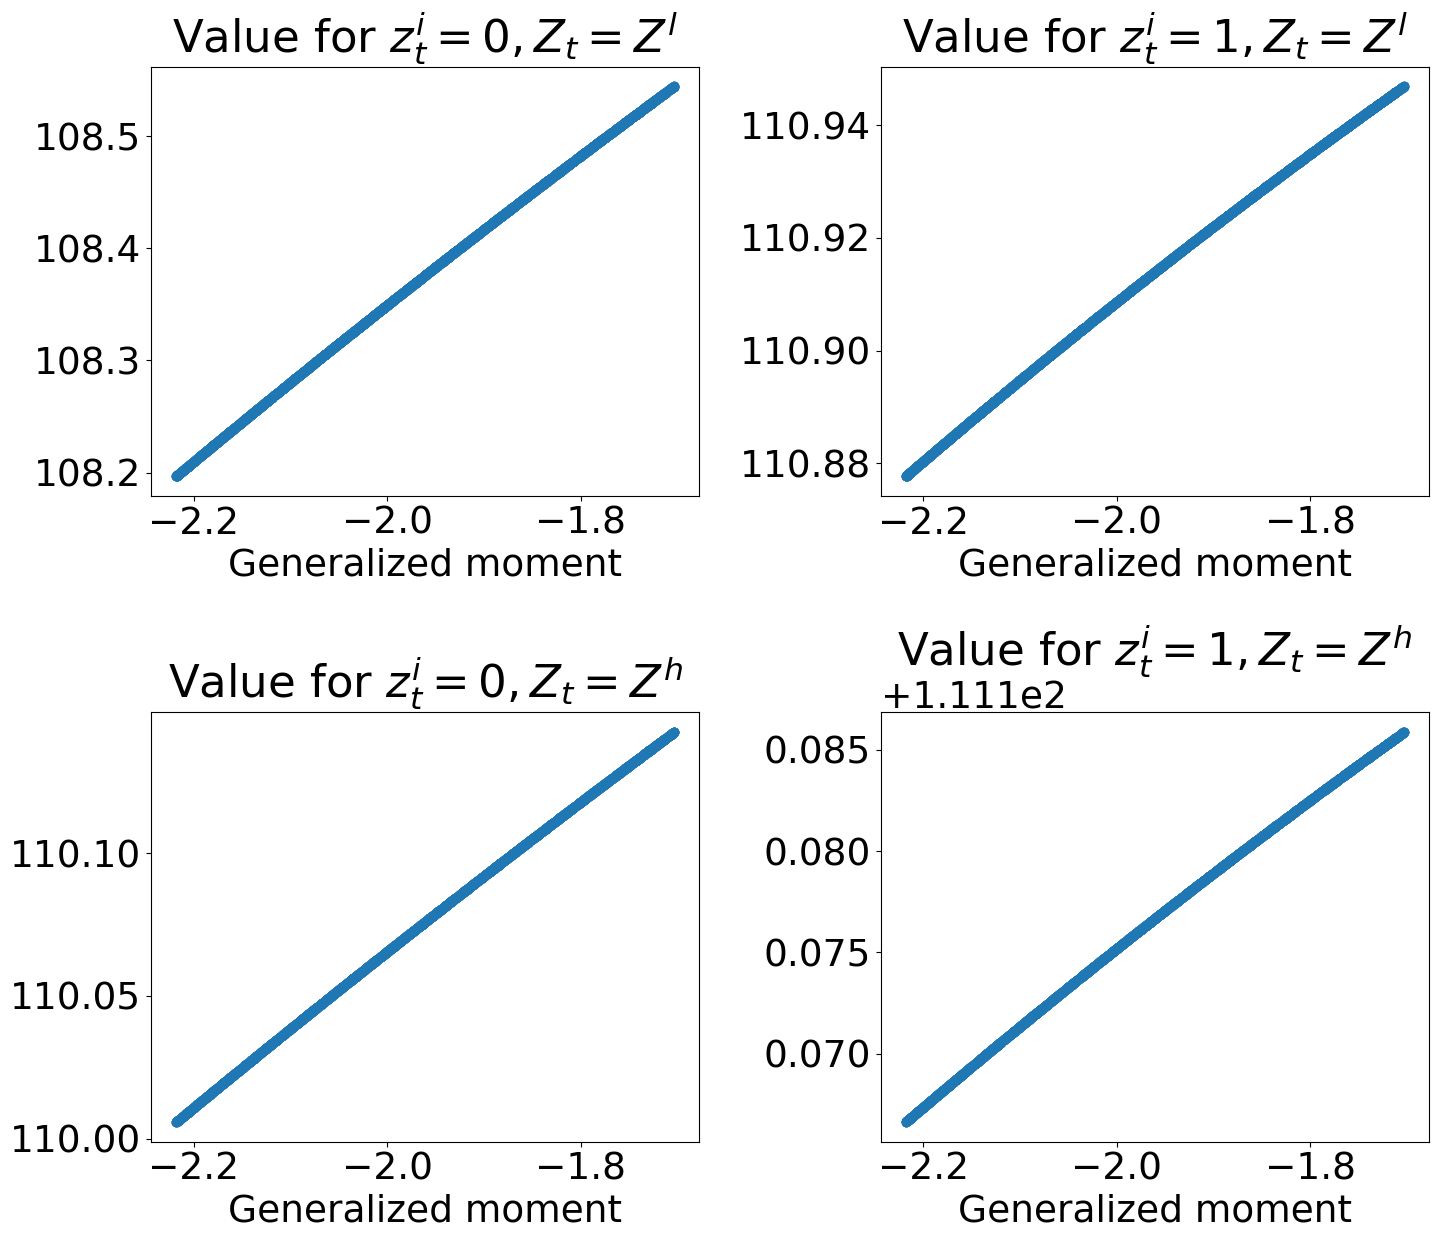

In [23]:
# simulate and plot value 0 against gm
basic_s_now, fm_extra_now, gm_now  = v_now(simul_data_nn, shocks, ptrainer, "nn", seed=1, nt=100)

gm_now0 = gm_now[0][:,0:1,:,0]
gm_now1 = gm_now[1][:,0:1,:,0]
gm_now2 = gm_now[2][:,0:1,:,0]
#sns.distplot(gm_now2.reshape((-1,1)),hist=True)
T_gm = 50
gm = np.random.uniform(np.min(gm_now2),np.max(gm_now2),(64,1,T_gm,1))

basic_s_now0 = basic_s_now[:,:,:,0]
basic_s_now1 = basic_s_now[:,:,:,1]
basic_s_now2 = basic_s_now[:,:,:,2]
basic_s_now3 = basic_s_now[:,:,:,3]

k_now = np.zeros_like(ishock[:,:,:T_gm])
K_now = np.zeros_like(ishock[:,:,:T_gm])
basic_s_now = np.stack([k_now, K_now, np.repeat(ashock[:, None, :T_gm], n_agt, axis=1), ishock[:,:,:T_gm]], axis=-1)

basic_s_input11 = basic_s_now.copy()
basic_s_input12 = basic_s_input11.copy()
basic_s_input21 = basic_s_input11.copy()
basic_s_input22 = basic_s_input11.copy()

basic_value = mparam.k_ss

basic_s_input11[:,:,:,0] = basic_value
basic_s_input11[:,:,:,2] = 0.99
basic_s_input11[:,:,:,3] = 0

basic_s_input12[:,:,:,0] = basic_value
basic_s_input12[:,:,:,2] = 0.99
basic_s_input12[:,:,:,3] = 1

basic_s_input21[:,:,:,0] = basic_value
basic_s_input21[:,:,:,2] = 1.01
basic_s_input21[:,:,:,3] = 0

basic_s_input22[:,:,:,0] = basic_value
basic_s_input22[:,:,:,2] = 1.01
basic_s_input22[:,:,:,3] = 1

gm = np.tile(gm, (1,50,1,1))
gm_now[0] = gm
gm_now[1] = gm_now[0].copy()
gm_now[2] = gm_now[0].copy()
v_out11, v0_11, v1_11, v2_11 = value_fn_nn(basic_s_input11, fm_extra_now, gm_now)
v_out12, v0_12, v1_12, v2_12 = value_fn_nn(basic_s_input12, fm_extra_now, gm_now)
v_out21, v0_21, v1_21, v2_21 = value_fn_nn(basic_s_input21, fm_extra_now, gm_now)
v_out22, v0_22, v1_22, v2_22 = value_fn_nn(basic_s_input22, fm_extra_now, gm_now)

gm_now0 = gm_now[0][:,0:1,:,0]
# normalize gm in the same way as normalize b
gm_now_mean = gm_now0/np.mean(basis_list[0])*np.mean(k_cross)

# in this example, we plot value 0 against gm
matplotlib.rcParams.update({'font.size': 27})
fig = plt.figure(figsize=(15,13))
ax = fig.add_subplot(221)
ax.scatter((gm_now_mean), (v0_11[:,0:1,:]))
ax.set_xlabel('Generalized moment')
ax.set_title(r'Value for $z^i_t = 0, Z_t = Z^l$')

ax = fig.add_subplot(222)
ax.scatter((gm_now_mean), (v0_12[:,0:1,:]))
ax.set_xlabel('Generalized moment')
#ax.set_title('Value for $z_g, Z_b$')
ax.set_title(r'Value for $z^i_t =1, Z_t = Z^l$')

ax = fig.add_subplot(223)
ax.scatter((gm_now_mean), (v0_21[:,0:1,:]))
ax.set_xlabel('Generalized moment')
#ax.set_title('Value for $z_b, Z_g$')
ax.set_title(r'Value for $z^i_t = 0, Z_t = Z^h$')

ax = fig.add_subplot(224)
ax.scatter((gm_now_mean), (v0_22[:,0:1,:]))
ax.set_xlabel('Generalized moment')
#ax.set_title('Value for $z_g, Z_g$')
ax.set_title(r'Value for $z^i_t = 1, Z_t = Z^h$')
plt.tight_layout()
fig.savefig('../output/KS_0fm1gm_gm_to_value.pdf', bbox_inches='tight')


## Path statistics & comparison (DeepHAM vs KS)


In [24]:
def path_stats(simul_data, beta, label=""):
    k_mean   = np.mean(simul_data["k_cross"], axis=1)
    T_len    = simul_data["csmp"].shape[-1]
    discount = np.power(beta, np.arange(T_len))
    util_sum = np.sum(np.log(simul_data["csmp"]) * discount, axis=-1)  # [paths, n_agt]
    print(
        f"{label:>8s}: total utility {util_sum.mean():.5f}, "
        f"k_mean {simul_data['k_cross'].mean():.5f}, "
        f"k_std {simul_data['k_cross'].std():.5f}, "
        f"k_max {simul_data['k_cross'].max():.5f}, "
        f"K_max {k_mean.max():.5f}"
    )

path_stats(simul_data_bchmk, mparam.beta, label="KS")
path_stats(simul_data_nn,     mparam.beta, label="DeepHAM")

      KS: total utility 104.31423, k_mean 39.29284, k_std 19.90378, k_max 159.65851, K_max 42.48806
 DeepHAM: total utility 104.26150, k_mean 39.40386, k_std 9.20371, k_max 143.69746, K_max 42.72360


## Plot aggregate trajectories: $K_t$ and $C_t$ (post-burn-in)

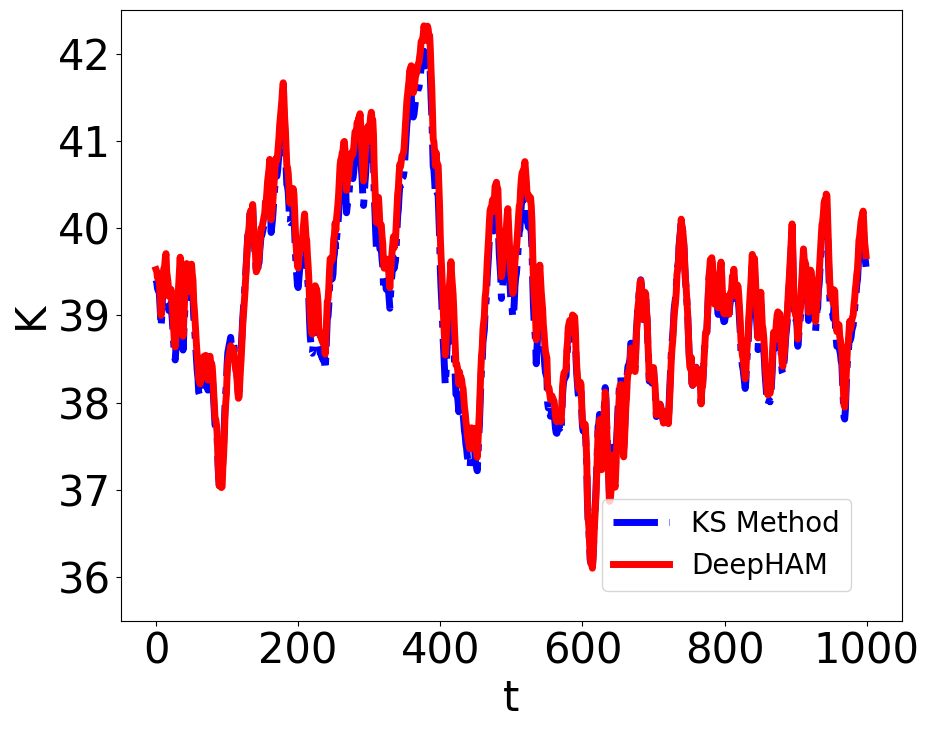

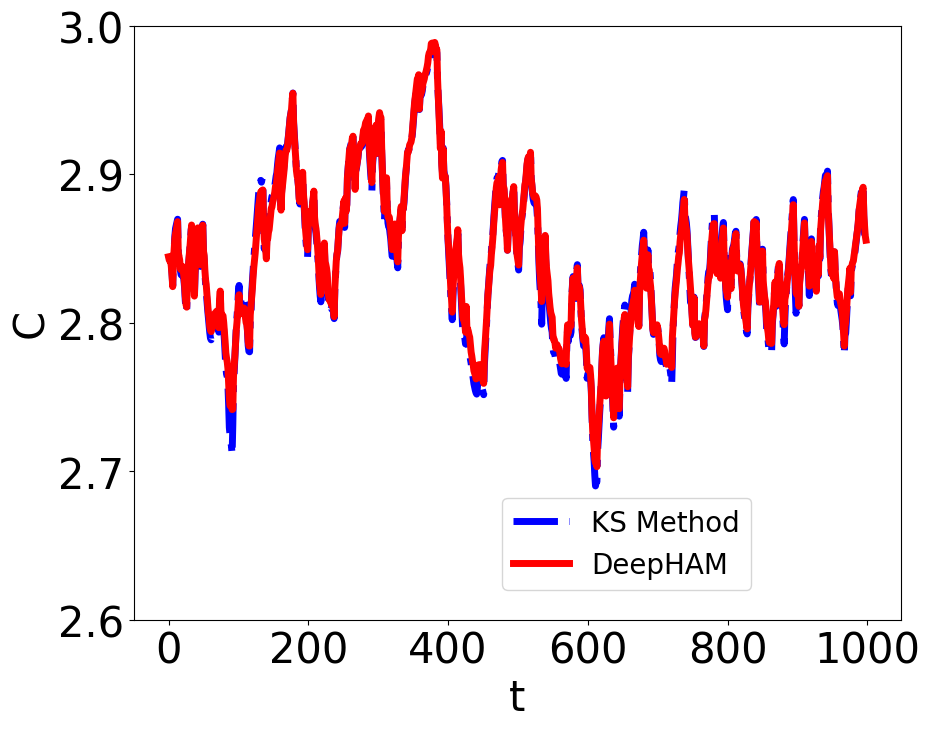

In [32]:

k_cross_bchmk, csmp_bchmk = simul_data_bchmk["k_cross"], simul_data_bchmk["csmp"]
k_cross_nn, csmp_nn = simul_data_nn["k_cross"], simul_data_nn["csmp"]

t0 = 1000
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
f1, = plt.plot(range(T - t0), np.mean(k_cross_bchmk[1,:,t0:],axis=(0)),'-.', color = 'b', linewidth=5)
f2, = plt.plot(range(T - t0), np.mean(k_cross_nn[1,:,t0:],axis=(0)), color = 'r', linewidth=5)
ax1.set_ylabel('K',fontsize=30)
ax1.set_xlabel('t',fontsize=30)
plt.ylim([35.5, 42.5])
fig.legend(handles=[f1,f2], labels=['KS Method', 'DeepHAM'],loc='upper right', bbox_to_anchor=(0.9, 0.35),fontsize=20)
#plt.title('KS Simulations: KS Method vs DeepHAM',fontsize=20)
plt.tight_layout()
fig.savefig('../output/KS_NN_sim_K_1000.pdf')
#

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
f1, = plt.plot(range(T - t0 - 1), np.mean(csmp_bchmk[1,:,t0:],axis=(0)),'-.', color = 'b', linewidth=5)
f2, = plt.plot(range(T - t0 - 1), np.mean(csmp_nn[1,:,t0:],axis=(0)), color = 'r', linewidth=5)
ax1.set_ylabel('C',fontsize=30)
ax1.set_xlabel('t',fontsize=30)
plt.ylim([2.6, 3])
fig.legend(handles=[f1,f2], labels=['KS Method', 'DeepHAM'],loc='upper right', bbox_to_anchor=(0.8, 0.35),fontsize=20)
#plt.title('KS Simulations: KS Method vs DeepHAM',fontsize=20)
plt.tight_layout()
fig.savefig('../output/KS_NN_sim_C_1000.pdf')